In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sys
import math
sys.path.append('/home/eduardo/PycharmProjects/treemap-analysis/code')

import Parser
import SpatialMetrics
import TemporalMetrics

In [9]:
dataset_id = ''

In [10]:
def styleBoxplot(bp, ax, n_revisions):
    
    def get_ax_size(ax):
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        return width, height
    
    for box in bp['boxes']:
        # change outline color
        box.set(color='#FFFFFF', linewidth=0)
        # change fill color
        box.set(facecolor='#1b9e77')
    for median in bp['medians']:
        median.set(color='#1445FF', linewidth=2)
    for whisker in bp['whiskers']:
        whisker.set(color='#CCCCCC', linestyle='-', linewidth=(get_ax_size(ax)[0]-1)/(n_revisions))
    for cap in bp['caps']:
        cap.set(color='#FFFFFF', linewidth=0)
        
    # Set only 3 ticks on x
    ax.set_xticks([1, n_revisions / 2, n_revisions], minor=False)
    ax.set_xticklabels([1, int(n_revisions / 2), n_revisions], fontdict=None, minor=False)
    
    # Remove extra spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', top='off')
    ax.tick_params(axis='y', which='both', right='off', left='off')

In [12]:
def cm2inch(value):
    return value/2.54

# Aggregated spatial metric boxplots

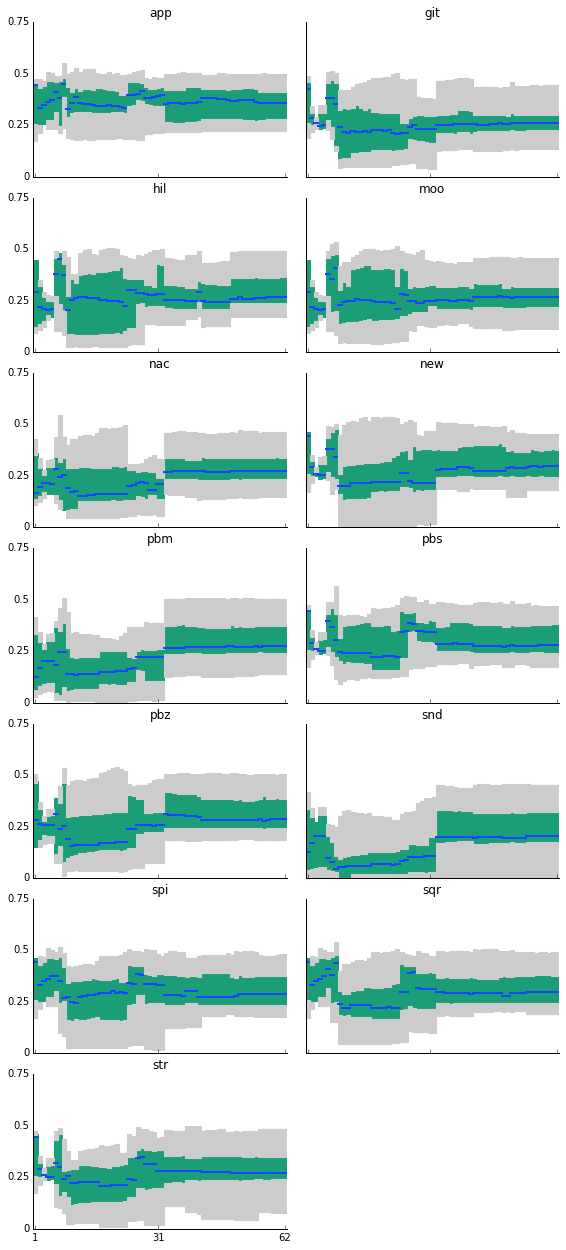

In [13]:
technique_list = Parser.list_techniques()
nrow = 7
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(cm2inch(20), cm2inch(2*22)))
fig.delaxes(axs[6, 1])
fig.tight_layout()

for i, ax in enumerate(fig.axes):
    if i < len(technique_list):
        ax.set_title(technique_list[i])
        df = SpatialMetrics.aggregated_ar(technique_list[i], dataset_id)

        data = []
        for r in df.as_matrix():
            data.append(r[~np.isnan(r)])

        bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
        styleBoxplot(bp, ax, len(data))
        
        ax.set_ylim([0, .75])
        ax.set_yticks([0, .25, .5, .75], minor=False)
        ax.set_yticklabels([0, .25, .5, .75], fontdict=None, minor=False)

fig.savefig('time-notebooks/svg/' + dataset_id + '_spatial.svg', format='svg', dpi=1200)

# Aggregated stability metrics boxplots
Unweighted Pearson correlation coefficient in red

In [ ]:
technique_list = Parser.list_techniques()
nrow = 7
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(cm2inch(20), cm2inch(2*22)))
fig.delaxes(axs[6, 1])
fig.tight_layout()
for i, ax in enumerate(fig.axes):
    ax.set_title(technique_list[i])
    df, pearson, weighted_pearson = TemporalMetrics.aggregated_stab(technique_list[i], dataset_id)

    data = []
    for r in df.as_matrix():
        data.append(r[~np.isnan(r)])

    bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
    
    ax.set_ylim(ymin=-0.05)
    ax.set_yticks([0, .25, .5, .75], minor=False)
    ax.set_yticklabels([0, .25, .5, .75], fontdict=None, minor=False)
    styleBoxplot(bp, ax, len(data))
    
    x = [i for i in range(len(pearson))]
    ax.plot(x, pearson, 'r_', ms=4, mew=2)

fig.savefig('time-notebooks/svg/' + dataset_id + '_stab.svg', format='svg', dpi=1200)